---
title: Sunspots and the Spectrum Model
---

We will revisit some sinusoidal models in the context of the sunspots data. We will then do some simulations illustrating the spectrum model. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp

(CVXPY) Mar 05 11:46:52 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libmkl_rt.2.dylib\n  Referenced from: <D8729A1C-CFE9-3397-89EC-E45F5ADDD8F2> /Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/../../libmkl_rt.2.dylib' (no such file), '/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/../../libmkl_rt.2.dylib' (no such file), '/Users/aditya/mambaforge/envs/stat153spring2025/bin/../lib/libmkl_rt.2.dylib' (no such file), '/Users/aditya/mambaforge/envs/stat153spring2025/bin/../lib/libmkl_rt.2.dylib' (no such file), '/usr/local/lib/libmkl_rt.2.dylib' (no such file), '/usr/lib/libmkl_rt.2.dylib' (no such file, not in dyld cache)")

## Sunspots Dataset

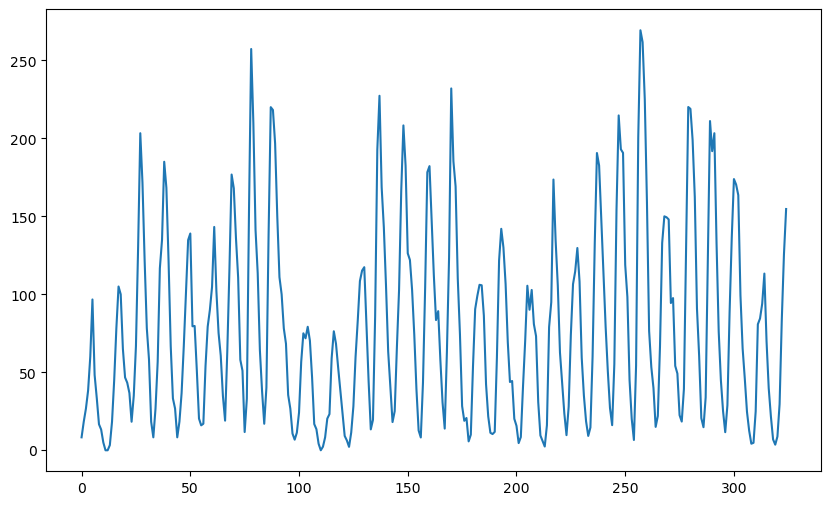

In [3]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.show()

One aspect of the sunspots dataset (that we ignored previously) is the following. The data shows clear peaks (as well as troughs). Further the distance between successive peaks varies from cycle to cycle. The following is an illustration of this. 

In [5]:
#peaks of a time series dataset can be found by using the following function from the signal processing module of scipy
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(y)
gaps = np.diff(peaks)
print("Peaks:", peaks)
print("Gaps between peaks:", gaps)


Peaks: [  5  17  27  38  50  52  61  69  78  87 102 104 116 130 137 148 160 164
 170 177 183 193 198 205 207 217 228 237 247 257 268 272 279 289 291 300
 314]
Gaps between peaks: [12 10 11 12  2  9  8  9  9 15  2 12 14  7 11 12  4  6  7  6 10  5  7  2
 10 11  9 10 10 11  4  7 10  2  9 14]


The gaps between the peaks is usually around 11 (but it can be as large as 14 and as small as 8). Sometimes we see a gap between peaks really small (such as 2) but this is most likely because of random fluctuation. 

Previously, for the sunspots dataset, we used the model: 
\begin{equation*}
    y_t = \beta_0 + \sum_{j=1}^k \left( \beta_{1j} \cos(2 \pi f_j t) + \beta_{2j} \sin(2 \pi f_j t) \right) + \epsilon_t
\end{equation*}
for this dataset. We discussed methods for estimating the parameters $\beta, f, \sigma$. The key role in parameter estimation is played by the RSS function. 

In [6]:
#rss function:
#below f is a vector (consisting of the k frequencies f1, \dots, fk)
def rss(f):
    n = len(y)
    X = np.column_stack([np.ones(n)])
    x = np.arange(1, n+1)
    if np.isscalar(f):
        f = [f]
    for j in range(len(f)):
        f1 = f[j]
        xcos = np.cos(2 * np.pi * f1 * x)
        xsin = np.sin(2 * np.pi * f1 * x)
        X = np.column_stack([X, xcos, xsin])
    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans


The model for $k = 1$ (where there is a single sinusoid) can be fit as follows. 

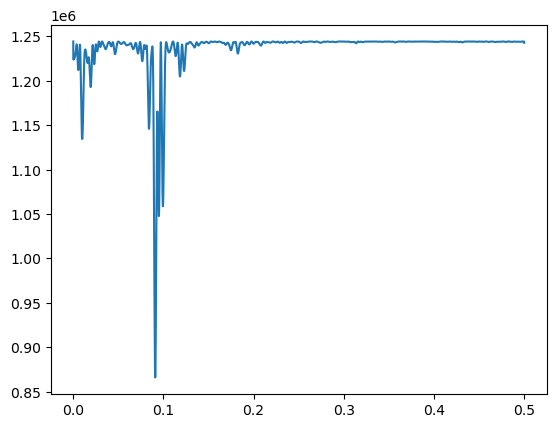

In [8]:
ngrid = 10000
fvals = np.linspace(0, 0.5, ngrid)
rssvals = np.array([rss(f) for f in fvals])
plt.plot(fvals, rssvals) #plot rss and find f which minimizes rss
plt.show()

In [9]:
#MLE of f:
fhat = fvals[np.argmin(rssvals)]
print(fhat)
print(1/fhat)

0.09090909090909091
11.0


The MLE of $f$ is basically $1/11$ (corresponding to the 11-year solar cycle). After estimating $f$, the other parameters ($\beta_0, \beta_1, \beta_2, \sigma$) are estimated as follows. 

In [10]:
#Estimates of beta and sigma: 
x = np.arange(1, n+1)
f = fhat
xcos = np.cos(2 * np.pi * f * x)
xsin = np.sin(2 * np.pi * f * x)
X = np.column_stack([np.ones(n), xcos, xsin])
md = sm.OLS(y, X).fit()
print(md.params) #this gives estimates of beta_0, beta_1, beta_2 
rss_fhat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_fhat/n)
sigma_unbiased = np.sqrt((rss_fhat)/(n-3))
print(np.array([sigma_mle, sigma_unbiased])) #sig is the true value of sigma which generated the data

[ 78.87599158 -38.28231622 -29.2786631 ]
[51.62376442 51.86369026]


While the single sinusoid model is useful (for example, it gives the period corresponding to the solar cycle), it ignores several important features of the sunspots dataset. One way to see this is to simulate synthetic data from the single sinusoid model and compare the synthetic data with the actual sunspots data. We will take the parameters $f, \beta, \sigma$ to be those estimated from the sunspots dataset to make the plots comparable to the actual sunspots data.

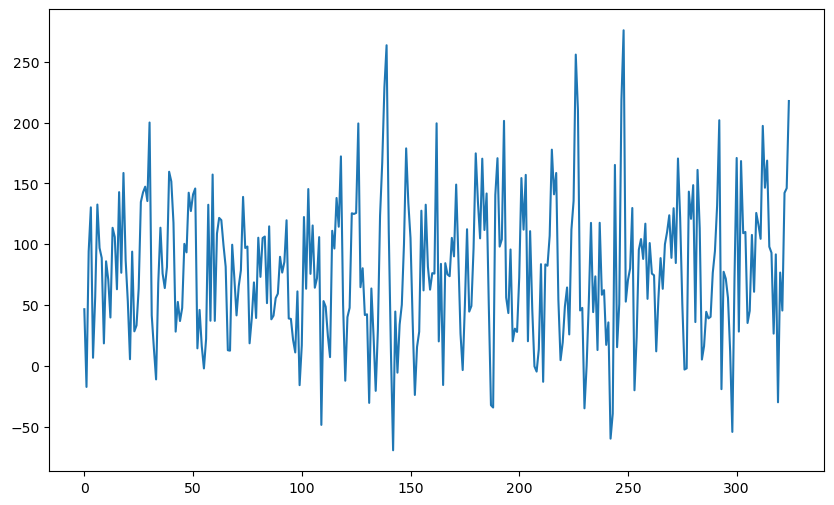

In [11]:
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
sim_data = md.fittedvalues + errorsamples
plt.figure(figsize = (10, 6))
plt.plot(sim_data)
plt.show()

To facilitate comparison with the actual sunspots dataset, let us plot a bunch of these simulated datasets along with the real sunspots data (just to see if the sunspots dataset can be spotted as the "odd one out" from these plots). 

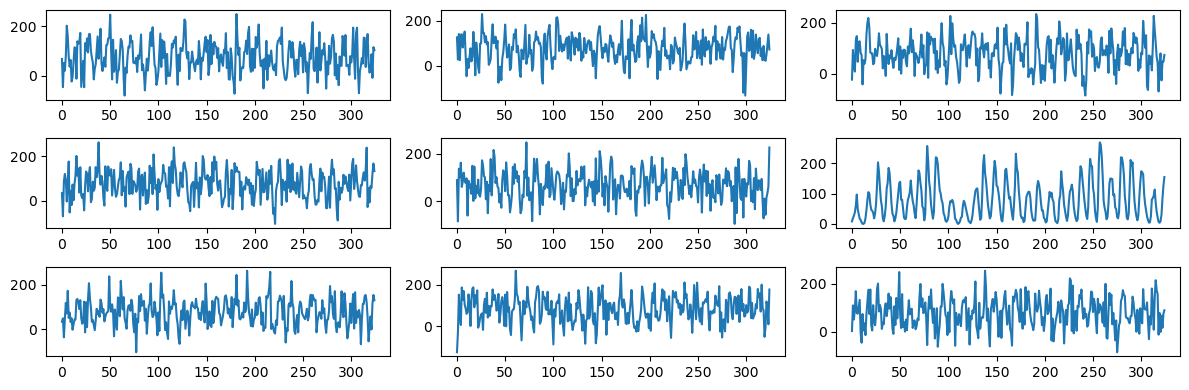

In [12]:
fig, axes = plt.subplots(3, 3, figsize = (12, 4))
axes = axes.flatten()
for i in range(5):
    errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
    sim_data = md.fittedvalues + errorsamples
    axes[i].plot(sim_data)
axes[5].plot(y)
for i, idx in enumerate(range(6, 9)):
    errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
    sim_data = md.fittedvalues + errorsamples
    axes[idx].plot(sim_data)
plt.tight_layout()
plt.show()

It is clear from the above plot-grid that the sunspots dataset sticks out as the odd one out. This shows that the simulated datasets (which are too wiggly and do not have well-defined peaks) are generated from a model that ignores many aspects of the sunspots dataset. 

The model does not get much better if we fit two (or even three) sinusoids. For two sinusoids, we saw previously (see Lecture 8) that the best frequencies are $f_1 = 0.0908$ and $f_2 = 0.0099$. The estimates of the other parameters is obtained as follows. 

In [13]:
f1 = 0.0908
f2 = 0.0099
#Estimates of other parameters: 
x = np.arange(1, n+1)
xcos = np.cos(2 * np.pi * f1 * x)
xsin = np.sin(2 * np.pi * f1 * x)
X = np.column_stack([np.ones(n), xcos, xsin])
xcos = np.cos(2 * np.pi * f2 * x)
xsin = np.sin(2 * np.pi * f2 * x)
X = np.column_stack([X, xcos, xsin])
md = sm.OLS(y, X).fit()
print(md.params) #this gives estimates of beta_0, beta_1, beta_2 
rss_fhat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_fhat/n)
sigma_unbiased = np.sqrt((rss_fhat)/(n-5))
print(np.array([sigma_mle, sigma_unbiased])) #sig is the true value of sigma which generated the data


[ 80.44664774 -41.7696879  -23.78505115 -19.26881092 -16.42834923]
[48.32168827 48.69773821]


Let us now plot synthetic data from this model, and then compare them to the actual data. 

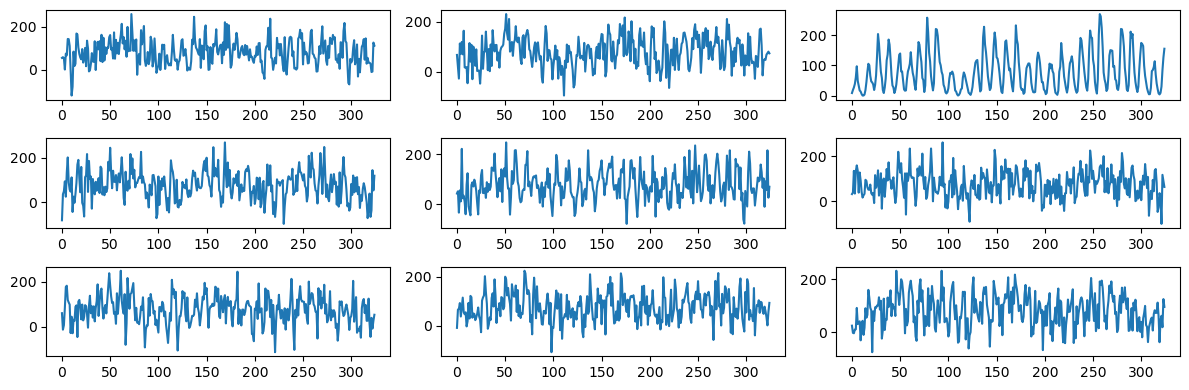

In [14]:
fig, axes = plt.subplots(3, 3, figsize = (12, 4))
axes = axes.flatten()
for i in range(2):
    errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
    sim_data = md.fittedvalues + errorsamples
    axes[i].plot(sim_data)
axes[2].plot(y)
for i, idx in enumerate(range(3, 9)):
    errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
    sim_data = md.fittedvalues + errorsamples
    axes[idx].plot(sim_data)
plt.tight_layout()
plt.show()

Again one can easily spot the sunspots data from this plot-grid. Let us now repeat this exercise with three frequency components (whose frequencies are fixed to the values that we previously obtained in the code of Lecture 8).

In [15]:
f1 = 0.0907
f2 = 0.01
f3 = 0.0998
#Estimates of other parameters: 
x = np.arange(1, n+1)
xcos = np.cos(2 * np.pi * f1 * x)
xsin = np.sin(2 * np.pi * f1 * x)
X = np.column_stack([np.ones(n), xcos, xsin])
xcos = np.cos(2 * np.pi * f2 * x)
xsin = np.sin(2 * np.pi * f2 * x)
X = np.column_stack([X, xcos, xsin])
xcos = np.cos(2 * np.pi * f3 * x)
xsin = np.sin(2 * np.pi * f3 * x)
X = np.column_stack([X, xcos, xsin])
md = sm.OLS(y, X).fit()
print(md.params) #this gives estimates of beta_0, beta_1, beta_2 
rss_fhat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_fhat/n)
sigma_unbiased = np.sqrt((rss_fhat)/(n-5))
print(np.array([sigma_mle, sigma_unbiased])) #sig is the true value of sigma which generated the data


[ 80.73881952 -43.5304532  -18.85510543 -17.48956354 -18.1002145
  30.36818441 -10.61894438]
[42.78339616 43.1163459 ]


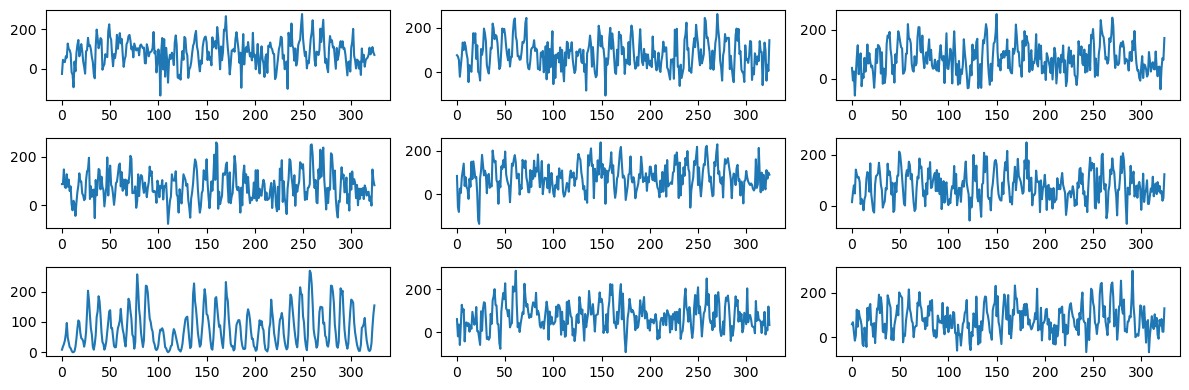

In [363]:
fig, axes = plt.subplots(3, 3, figsize = (12, 4))
axes = axes.flatten()
for i in range(6):
    errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
    sim_data = md.fittedvalues + errorsamples
    axes[i].plot(sim_data)
axes[6].plot(y)
for i, idx in enumerate(range(7, 9)):
    errorsamples = rng.normal(loc = 0, scale = sigma_mle, size = n)
    sim_data = md.fittedvalues + errorsamples
    axes[idx].plot(sim_data)
plt.tight_layout()
plt.show()

The plots now look closer to the actual sunspots data, but still are quite a bit more wiggly (without clearly defined peaks) compared to the actual data. 

## Ridge and LASSO regression with sinusoids

Let us now try the high-dimensional version of the sinusoidal model where we use sinusoids at all the Fourier frequencies:
\begin{equation*}
   y_t = \beta_0 + \sum_{j = 1}^{(n-1)/2} \left( \beta_{1j} \cos(2 \pi (j/n) t) + \beta_{2j} \sin (2 \pi (j/n) t) \right) + \epsilon_t
\end{equation*}
Here $n = 325$ is odd. If $n$ were even, we will add another term for $\cos (\pi t)$. 

We would need to use some kind of regularization for meaningful estimation in this high-dimensional regression model. It is natural to try ridge or LASSO regularization. These will make the size of the coefficients $\beta_{1j}, \beta_{2j}$ small but this may not produce anything useful in this dataset. Let us illustrate this below. 

The first step for implementing ridge or LASSO regularization is to create the $X$ matrix.

In [16]:
#Creating the X matrix
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
m = (n-1)//2
for j in range(m):
    f = j/n
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([X, xcos, xsin])

We will use the same code for ridge and LASSO regression that we used last week. 

In [17]:
#note that penalty_start is now set to 1 (instead of 2 as in the model used in class)
def solve_ridge(X, y, lambda_val, penalty_start=1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

In [18]:
#note that penalty_start is now set to 1 (instead of 2 as in the model used in class)
def solve_lasso(X, y, lambda_val, penalty_start=1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

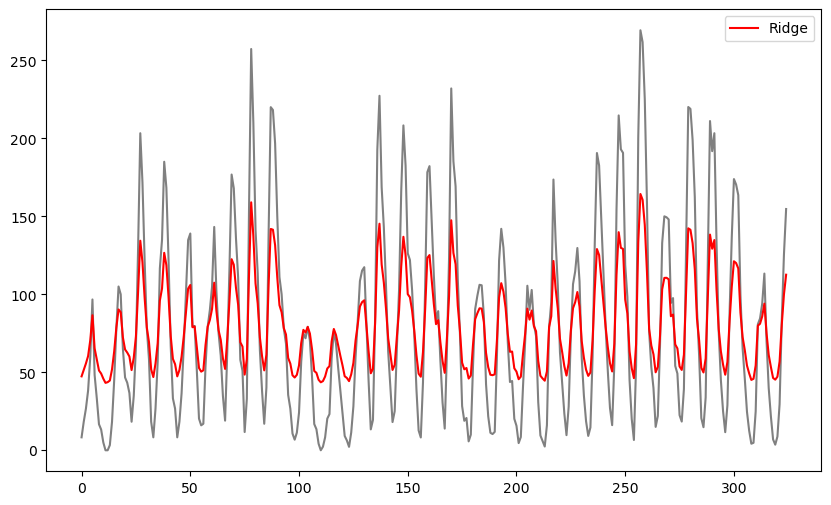

In [20]:
b_ridge = solve_ridge(X, y, lambda_val = 200)
ridge_fitted = np.dot(X, b_ridge)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'gray')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.legend()
plt.show()

The fitted values produced by ridge regression appear to be very similar to the original data values but shrunk towards the overall mean of the data. The extent of shrinkage is controlled by the value of $\lambda$ (when $\lambda$ is small, these fitted values will be very close to the actual observations) It is unclear how these fitted values may be interpreted or how may they be useful. We can also estimate $\sigma$ and plot simulated datasets, and compare with the original dataset. 

In [21]:
sig_ridge = np.sqrt((np.sum((y - ridge_fitted) ** 2))/n)
print(sig_ridge)

34.13721232125516


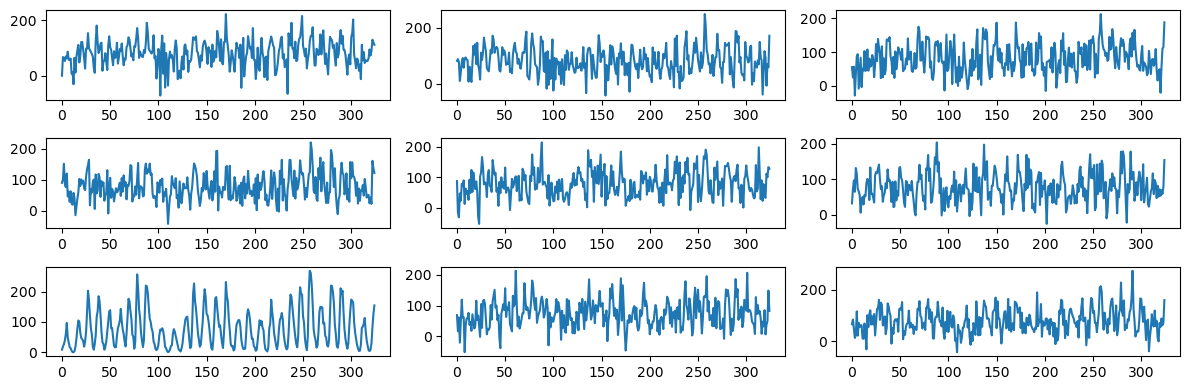

In [22]:
fig, axes = plt.subplots(3, 3, figsize = (12, 4))
axes = axes.flatten()
for i in range(6):
    errorsamples = rng.normal(loc = 0, scale = sig_ridge, size = n)
    sim_data = ridge_fitted + errorsamples
    axes[i].plot(sim_data)
axes[6].plot(y)
for i, idx in enumerate(range(7, 9)):
    errorsamples = rng.normal(loc = 0, scale = sig_ridge, size = n)
    sim_data = ridge_fitted + errorsamples
    axes[idx].plot(sim_data)
plt.tight_layout()
plt.show()

As before, one can easily spot the sunspots data from this plot-grid.

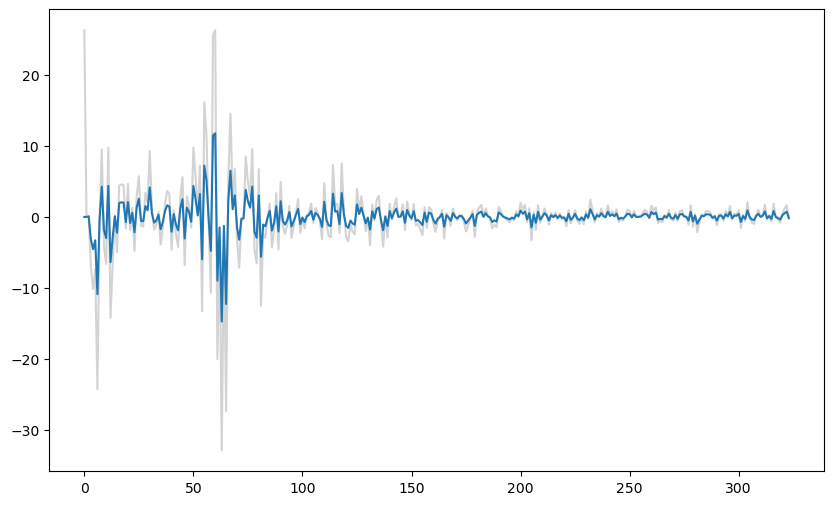

In [28]:
#To illustrate the shrinkage effect of the ridge coefficients, below we compare the ridge coefficients with the unregularized estimates of the coefficients
#the unregularized estimates correspond to lambda equaling 0
b_ridge_0 = solve_ridge(X, y, lambda_val = 0)
plt.figure(figsize = (10, 6))
plt.plot(b_ridge_0[1:], color = 'lightgray')
plt.plot(b_ridge[1:])
plt.show()

Next let us use LASSO regularization. 

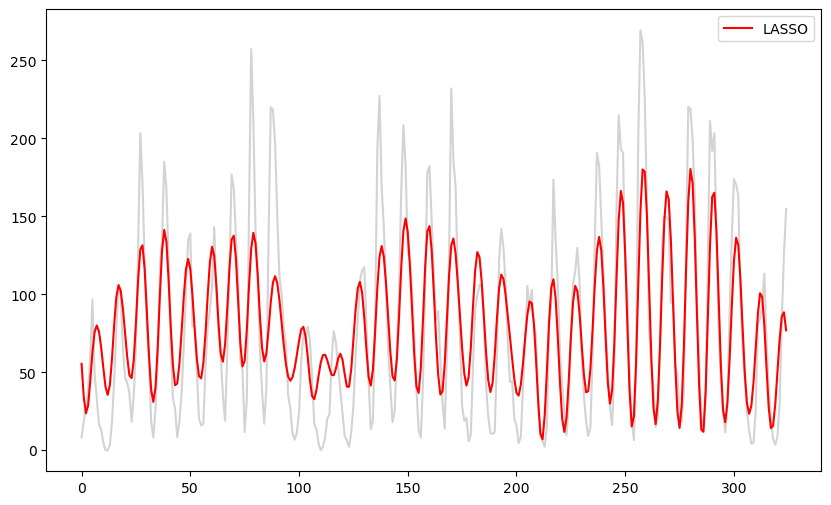

In [29]:
b_lasso = solve_lasso(X, y, lambda_val = 2000)
lasso_fitted = np.dot(X, b_lasso)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.legend()
plt.show()

These fitted values look similar to the fitted values for the model with three sinusoidal components. This is unsurprising as the LASSO zeroes out many of the components so that the fitted model will be a sum of a small (but probably more than 3) sinusoidal components. This model might be useful for prediction. But data simulated from it (with $\sigma$ estimated as below) will still be wiggly without clearly defined peaks. 

In [30]:
sig_lasso = np.sqrt((np.sum((y - lasso_fitted) ** 2))/n)
print(sig_lasso)

33.54702098714371


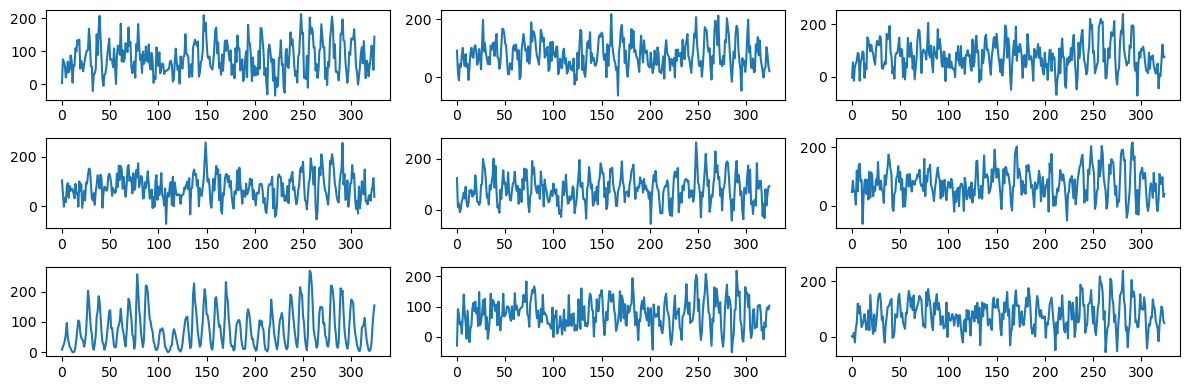

In [31]:
fig, axes = plt.subplots(3, 3, figsize = (12, 4))
axes = axes.flatten()
for i in range(6):
    errorsamples = rng.normal(loc = 0, scale = sig_lasso, size = n)
    sim_data = lasso_fitted + errorsamples
    axes[i].plot(sim_data)
axes[6].plot(y)
for i, idx in enumerate(range(7, 9)):
    errorsamples = rng.normal(loc = 0, scale = sig_lasso, size = n)
    sim_data = lasso_fitted + errorsamples
    axes[idx].plot(sim_data)
plt.tight_layout()
plt.show()

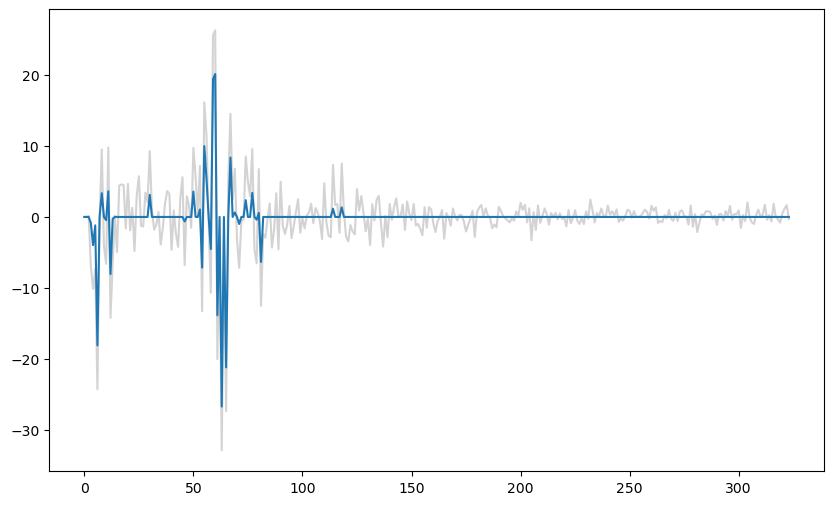

In [32]:
#To illustrate the sparsity nature of LASSO coefficients, below we compare the LASSO coefficients with the unregularized estimates of the coefficients
#the unregularized estimates correspond to lambda equaling 0
b_lasso_0 = solve_lasso(X, y, lambda_val = 0)
plt.figure(figsize = (10, 6))
plt.plot(b_lasso_0[1:], color = 'lightgray')
plt.plot(b_lasso[1:])
plt.show()

It is clear from the above plot that most of the small unregularized coefficients are set to exactly zero by LASSO.

## The Spectrum Model

To obtain the spectrum model, we shall first remove the $\epsilon_t$ and write: 
\begin{equation*}
   y_t = \beta_0 + \sum_{j = 1}^{m} \left( \beta_{1j} \cos(2 \pi (j/n) t) + \beta_{2j} \sin (2 \pi (j/n) t) \right)
\end{equation*}
where $m := (n-1)/2$. We further assume that 
\begin{equation*}
    \beta_{1j}, \beta_{2j} \overset{\text{i.i.d}}{\sim} N(0, \tau_j^2)
\end{equation*}
The variances $\tau_1^2, \dots, \tau_m^2$ denote the unknown parameters in the model (collectively, they are known as the spectrum of the model).

The variance parameter $\tau_j^2$ represents how much contribution the corresponding frequency $j/n$ has in the overall variance structure of $y_t$. If $\tau_j^2$ is large for a specific $j$, the corresponding frequency $j/n$ has a strong contribution to the data. If $\tau_j^2$ is small, the contribution of that frequency is small. 

The total variance of $y_t$ is given by:
\begin{equation*}
   \text{var}(y_t) = \sum_{j=1}^m \tau_j^2. 
\end{equation*}
This reflects how the variance of the signal is distributed across different frequency components. 

The sequence $\{\tau_j^2\}$ provides a **spectral representation** of the time series, in the sense that it describes the distribution of variance across frequencies. 

Below we take some fixed spectrum i.e., we fix $\tau_j^2, j = 1, \dots, m$ and simulate data from the spectrum model. The goal is to get a sense of the kind of data we would get for different spectra. 

### Example One

The first example corresponds to the case where $\tau_j^2$ takes a constant value when $j/n$ lies between $1/13$ and $1/9$ and then zero for other values of $j/n$. Frequencies between $1/13$ and $1/9$ contributed equally to this data while no other frequency has any contribution. Let us see how the data looks. 

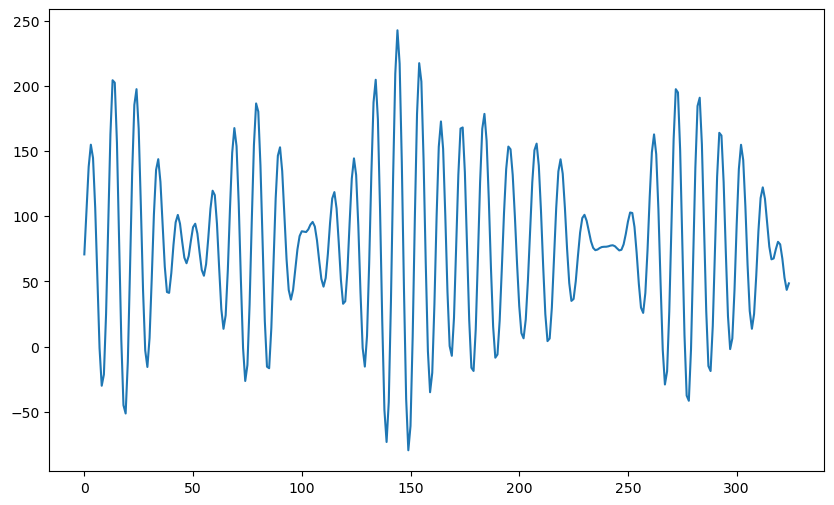

In [65]:
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
m = (n-1)//2
for j in range(m):
    f = j/n
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([X, xcos, xsin])

tau_t = np.zeros(m)
lf = n // 13
uf = n // 9
y = sunspots.iloc[:,1].values
tau_t[lf:uf] = np.sqrt(np.var(y)/(uf - lf))

b_coeff = np.zeros(n)
b_coeff[0] = np.mean(y) #we are using the mean of the sunspots dataset for b0
for j in range(m):
    tauval = tau_t[j]
    aj = rng.normal(loc = 0, scale = tauval, size = 1)
    bj = rng.normal(loc = 0, scale = tauval, size = 1)
    b_coeff[(2*j)+1] = aj.item()
    b_coeff[(2*j)+2] = bj.item()
simvals = np.dot(X, b_coeff)
plt.figure(figsize = (10, 6))
plt.plot(simvals)
plt.show()

The data looks quite smooth (without any seemingly random fluctuation). Let us look at the peaks and the gaps between them.

In [66]:
# Find peaks
peaks, _ = find_peaks(simvals)
gaps = np.diff(peaks)
print("Peaks:", peaks)
print("Gaps between peaks:", gaps)

Peaks: [  3  13  24  34  43  51  59  69  79  90 100 105 115 124 134 144 154 164
 174 184 195 208 219 230 243 251 262 272 283 292 302 312 319]
Gaps between peaks: [10 11 10  9  8  8 10 10 11 10  5 10  9 10 10 10 10 10 10 11 13 11 11 13
  8 11 10 11  9 10 10  7]


The gaps between the peaks varies in a way that is somewhat reminiscent of the sunspots dataset. 

We can try to fit a single sinusoid model to this dataset to see which frequency estimate it gives. 

9.619047619047619


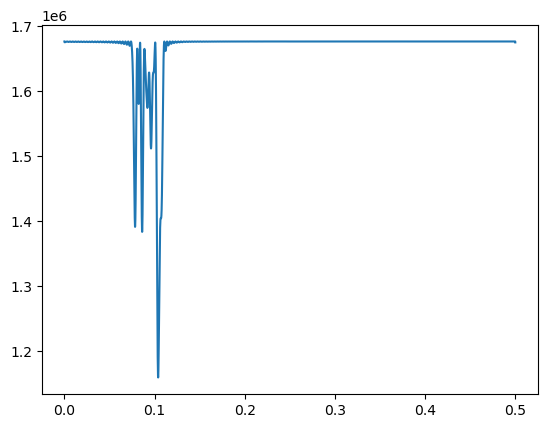

In [41]:
y = simvals
ngrid = 10000
fvals = np.linspace(0, 0.5, ngrid)
rssvals = np.array([rss(f) for f in fvals])
plt.plot(fvals, rssvals)
fhat = fvals[np.argmin(rssvals)]
print(1/fhat)

### Example Two

In the second example, we take $\tau_j^2$ to equal some constant value when the $j/n$ lies between $1/13$ and $1/9$, and some other constant value when $j/n$ lies between $1/25$ and $1/22$. We will take it to be zero for all other frequencies. 

78.76


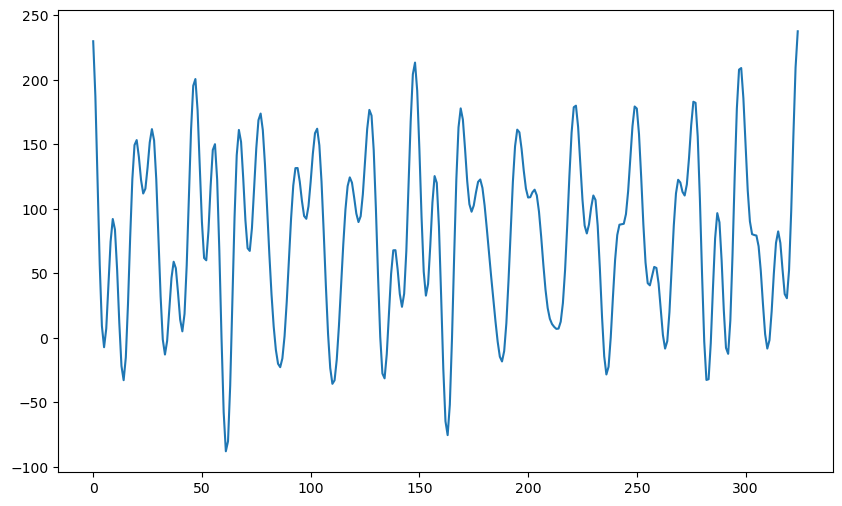

In [67]:
tau_t = np.zeros(m)
lf = n // 13
uf = n // 9
tau_t[lf:uf] = np.sqrt(1/(uf - lf))
lf2 = n//25
uf2 = n//22
tau_t[lf2:uf2] = np.sqrt(1/(uf2 - lf2))
y = sunspots.iloc[:,1].values
tau_t = np.sqrt(np.var(y)) * (tau_t/np.sqrt(np.sum(tau_t ** 2)))


b_coeff = np.zeros(n)
b_coeff[0] = np.mean(y)
print(b_coeff[0])
for j in range(m):
    tauval = tau_t[j]
    aj = rng.normal(loc = 0, scale = tauval, size = 1)
    bj = rng.normal(loc = 0, scale = tauval, size = 1)
    b_coeff[(2*j)+1] = aj
    b_coeff[(2*j)+2] = bj
simvals = np.dot(X, b_coeff)
plt.figure(figsize = (10, 6))
plt.plot(simvals)
plt.show()

This dataset visually seems more similar to the sunspots data compared to the previous datasets with lots of random fluctuations.

In [68]:
peaks, _ = find_peaks(simvals)
gaps = np.diff(peaks)
print("Peaks:", peaks)
print("Gaps between peaks:", gaps)

Peaks: [  9  20  27  37  47  56  67  77  94 103 118 127 139 148 157 169 178 195
 203 222 230 249 258 269 276 287 298 315]
Gaps between peaks: [11  7 10 10  9 11 10 17  9 15  9 12  9  9 12  9 17  8 19  8 19  9 11  7
 11 11 17]


Again the gaps between the peaks varies over the course of the dataset (which happens in the actual sunspots dataset as well).

### Example Three

In the third example, we take the spectrum to be given by a decreasing or increasing sequence of $\tau_j^2$. 

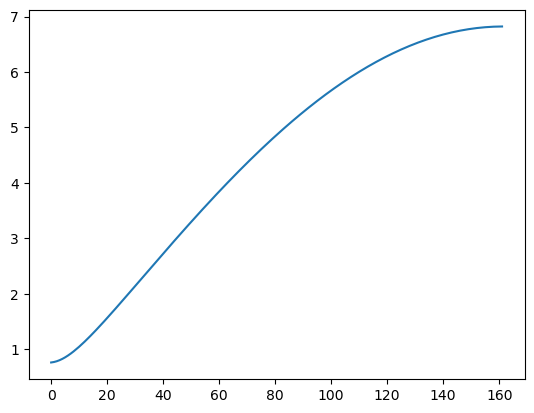

In [55]:
freqs = (np.arange(1, m+1))/n
th = -0.8
tau_t = np.sqrt((1 + (th ** 2) + 2*th*np.cos(2 * np.pi * freqs)))
#when th>0, these tau_t values are decreasing. 
#when th<0, these tau_t values are increasing
y = sunspots.iloc[:,1].values
tau_t = np.sqrt(np.var(y)) * (tau_t/np.sqrt(np.sum(tau_t ** 2)))
plt.plot(tau_t)
plt.show()

78.76


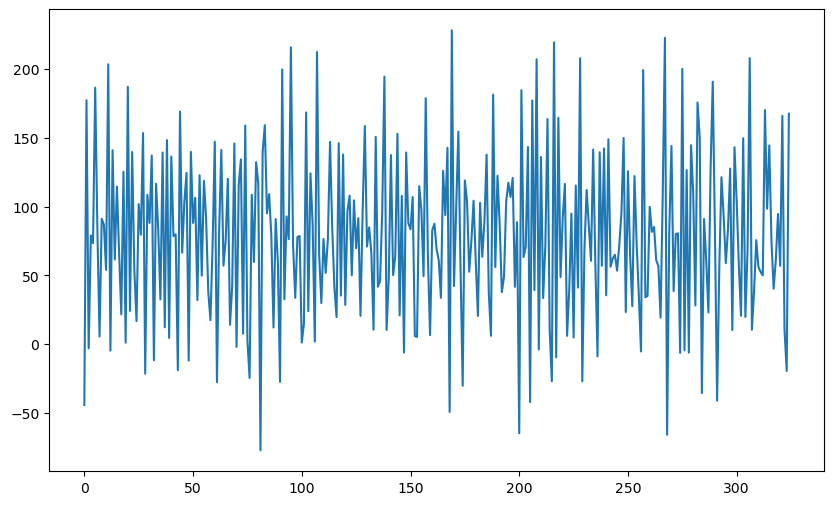

In [56]:
b_coeff = np.zeros(n)
b_coeff[0] = np.mean(y)
print(b_coeff[0])
for j in range(m):
    tauval = tau_t[j]
    aj = rng.normal(loc = 0, scale = tauval, size = 1)
    bj = rng.normal(loc = 0, scale = tauval, size = 1)
    b_coeff[(2*j)+1] = aj
    b_coeff[(2*j)+2] = bj
simvals = np.dot(X, b_coeff)
plt.figure(figsize = (10, 6))
plt.plot(simvals)
plt.show()

Change the $\tau_t$ values from increasing to decreasing, and then examine how the plot of the data changes. 

### Example Four

Here we take $\tau_j^2$ to be peaked for $j/n$ which is close to 11. 

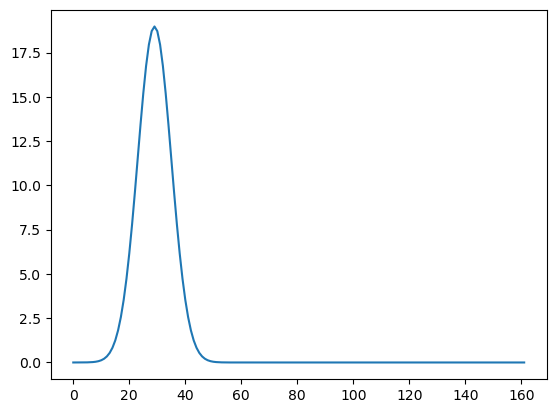

In [62]:
#the following tau_j^2 is peaked around j/n = 1/11 and then drops quickly as j/n moves away from 1/11
j_vals = np.arange(m)
# Define the peak position and width (smaller width makes it drop quickly)
peak_pos = n // 11
width = n // 50  # Adjust width for quicker drop-off
tau_t = 100*np.exp(-((j_vals - peak_pos) ** 2) / (2 * width ** 2))
tau_t = np.sqrt(np.var(y)) * (tau_t / np.sqrt(np.sum(tau_t ** 2)))
plt.plot(tau_t)
plt.show()

78.76


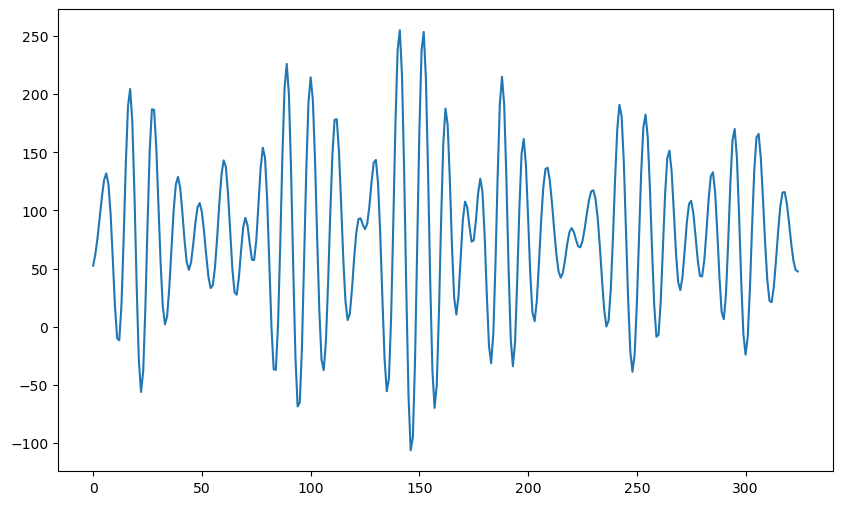

In [63]:
b_coeff = np.zeros(n)
b_coeff[0] = np.mean(y)
print(b_coeff[0])
for j in range(m):
    tauval = tau_t[j]
    aj = rng.normal(loc = 0, scale = tauval, size = 1)
    bj = rng.normal(loc = 0, scale = tauval, size = 1)
    b_coeff[(2*j)+1] = aj
    b_coeff[(2*j)+2] = bj
simvals = np.dot(X, b_coeff)
plt.figure(figsize = (10, 6))
plt.plot(simvals)
plt.show()

In [69]:
peaks, _ = find_peaks(simvals)
gaps = np.diff(peaks)
print("Peaks:", peaks)
print("Gaps between peaks:", gaps)

Peaks: [  9  20  27  37  47  56  67  77  94 103 118 127 139 148 157 169 178 195
 203 222 230 249 258 269 276 287 298 315]
Gaps between peaks: [11  7 10 10  9 11 10 17  9 15  9 12  9  9 12  9 17  8 19  8 19  9 11  7
 11 11 17]


## Estimating the spectrum by smoothing the periodogram

In the next lecture, we shall see how to estimate the spectrum from observed data. The main idea is to smooth the periodogram. This is illustrated below (details will be given in the next lecture).

In [71]:
y = sunspots.iloc[:,1].values
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y


Below we compute the periodogram, and plot its logarithm. 

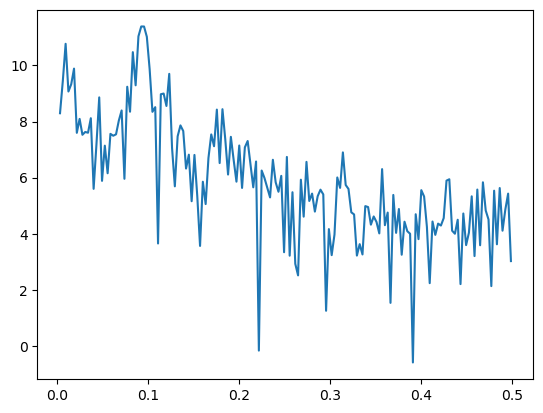

In [72]:
freqs, pgram = periodogram(y)
plt.plot(freqs, np.log(pgram))
plt.show()

The following function computes the estimate of $\log \tau_j$ (below $\log \tau_j$ is denoted by $\alpha_j$).

In [76]:
def spectrum_estimator(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)  # Length of original time series
    alpha = cp.Variable(m)
    likelihood_term = cp.sum(cp.multiply((2 * I / n), cp.exp(-2 * alpha)) + alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return alpha.value, freq  # Return estimated log spectral density and frequencies


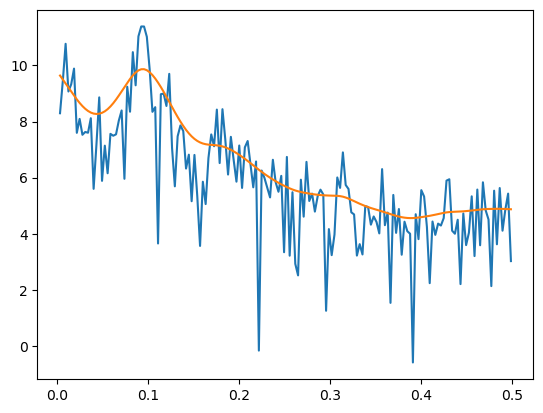

In [85]:
alpha_opt, freq = spectrum_estimator(y, 1000)
#Below we plot the log(periodogram) and the fitted spectrum estimator on the same plot
#This illustrates how the spectrum estimate can be viewed as a smoothing of the periodogram
plt.plot(freqs, np.log(pgram))
plt.plot(freqs, np.log(n/4) + 2*alpha_opt)
plt.show()


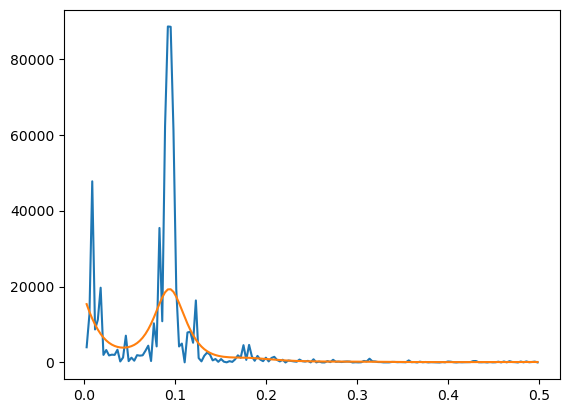

In [86]:
#Below we plot the peridogram and its smoothed version (on the original scale without the logarithms)
plt.plot(freqs, pgram)
plt.plot(freqs, (n/4)*np.exp(2*alpha_opt))
plt.show()


Below is the plot of the estimated spectrum.

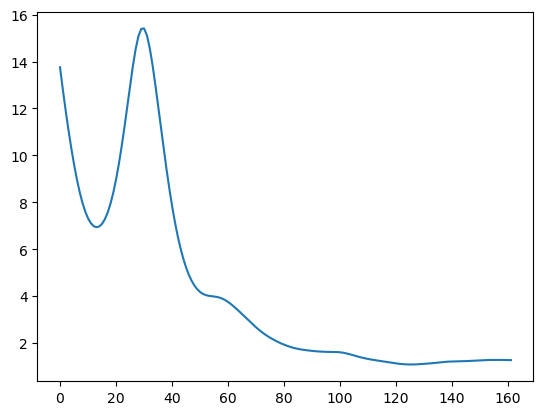

In [89]:
#Estimated spectrum
tau_opt = np.exp(alpha_opt)
plt.plot(tau_opt)
plt.show()

Below we simulate data from this spectrum. 

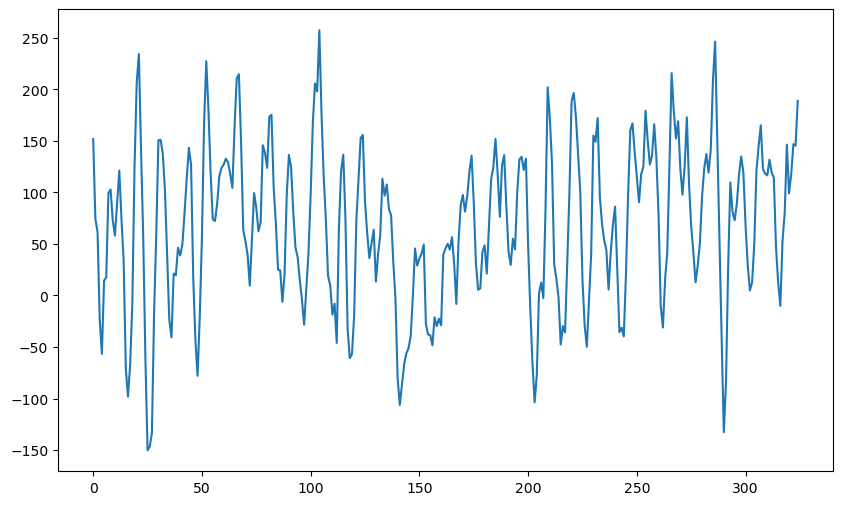

In [90]:
b_coeff = np.zeros(n)
b_coeff[0] = np.mean(y)
for j in range(m):
    tauval = tau_opt[j]
    aj = rng.normal(loc = 0, scale = tauval, size = 1)
    bj = rng.normal(loc = 0, scale = tauval, size = 1)
    b_coeff[(2*j)+1] = aj
    b_coeff[(2*j)+2] = bj
simvals = np.dot(X, b_coeff)
plt.figure(figsize = (10, 6))
plt.plot(simvals)
plt.show()

The following are the peaks and the gaps between them for the above simulated dataset.

In [92]:
peaks, _ = find_peaks(simvals)
gaps = np.diff(peaks)
print("Peaks:", peaks)
print("Gaps between peaks:", gaps)

Peaks: [  3  14  18  23  33  43  45  51  60  62  67  76  88  94 100 112 117 126
 134 140 144 150 154 156 158 163 167 171 180 184 191 197 199 204 206 209
 215 221 233 242 244 247 261 263 266 269 272 275 280 284 286 291 293 303
 313 323]
Gaps between peaks: [11  4  5 10 10  2  6  9  2  5  9 12  6  6 12  5  9  8  6  4  6  4  2  2
  5  4  4  9  4  7  6  2  5  2  3  6  6 12  9  2  3 14  2  3  3  3  3  5
  4  2  5  2 10 10 10]


The following are the peaks and the gaps between them for the actual sunspots dataset. 

In [93]:
peaks, _ = find_peaks(y)
gaps = np.diff(peaks)
print("Peaks:", peaks)
print("Gaps between peaks:", gaps)

Peaks: [  5  17  27  38  50  52  61  69  78  87 102 104 116 130 137 148 160 164
 170 177 183 193 198 205 207 217 228 237 247 257 268 272 279 289 291 300
 314]
Gaps between peaks: [12 10 11 12  2  9  8  9  9 15  2 12 14  7 11 12  4  6  7  6 10  5  7  2
 10 11  9 10 10 11  4  7 10  2  9 14]


We simulate a bunch of these datasets and compare them to the original sunspots data.

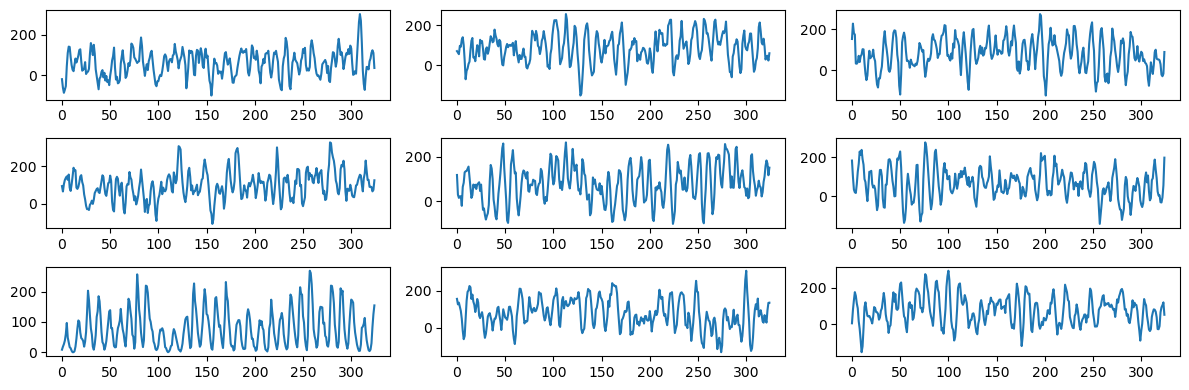

In [91]:
fig, axes = plt.subplots(3, 3, figsize = (12, 4))
axes = axes.flatten()
for i in range(6):
    b_coeff = np.zeros(n)
    b_coeff[0] = np.mean(y)
    for j in range(m):
        tauval = tau_opt[j]
        aj = rng.normal(loc = 0, scale = tauval, size = 1)
        bj = rng.normal(loc = 0, scale = tauval, size = 1)
        b_coeff[(2*j)+1] = aj
        b_coeff[(2*j)+2] = bj
        simvals = np.dot(X, b_coeff)
    axes[i].plot(simvals)
axes[6].plot(y)
for i, idx in enumerate(range(7, 9)):
    b_coeff = np.zeros(n)
    b_coeff[0] = np.mean(y)
    for j in range(m):
        tauval = tau_opt[j]
        aj = rng.normal(loc = 0, scale = tauval, size = 1)
        bj = rng.normal(loc = 0, scale = tauval, size = 1)
        b_coeff[(2*j)+1] = aj
        b_coeff[(2*j)+2] = bj
        simvals = np.dot(X, b_coeff)
    axes[idx].plot(simvals)
plt.tight_layout()
plt.show()

The simulated datasets still look different from the actual sunspots dataset. But they are not as wiggly as before and seem to have well-defined peaks with gaps between peaks varying as in the actual sunspots dataset. 